<h3>Customer Churn Prediction of a Telecom Company</h3>
<p>Churn is when a customer or a user leaves or stops engaging with a service or a platform. It is critical as acquiring new customer is costly. It also affects growth of a company. Small increase in retention can significantly increase the profit.</p>

<h3>Import Libraries</h3>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

<h3>Data Loading</h3>

In [3]:
#load the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display the first 5 rows
print(df.head())

# Display data types and non-null counts
print(df.info())

# Confirm missing values (should match what you provided)
print(df.isnull().sum())

# Confirm churn distribution (should match what you provided)
print(df['Churn'].value_counts(normalize=True))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

<h3>Data cleaning and preprocessing </h3>
<p>Convert TotalCharges to float64 to handle non-numeric values.Check for duplicates based on customerID (since it should be unique). Encode categorical variables (e.g., Yes/No to 1/0) for simpler preprocessing later.Drop customerID as it’s not predictive.</p>

In [4]:
# 1. Convert TotalCharges to float, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for any NaN values introduced in TotalCharges
print("NaN values after TotalCharges conversion:")
print(df['TotalCharges'].isnull().sum())

# Fill NaN in TotalCharges (e.g., with 0 or impute based on tenure * MonthlyCharges)
df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

# 2. Check for duplicate customerIDs
print("Duplicate customerIDs:", df['customerID'].duplicated().sum())

# Drop customerID as it's not predictive
df = df.drop('customerID', axis=1)

# 3. Convert binary categorical columns to 0/1
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Male': 1, 'Female': 0, 'Yes': 1, 'No': 0})

# Verify data types and first few rows after cleaning
print(df.info())
print(df.head())

# Save cleaned dataset for next steps
df.to_csv('cleaned_telco_data.csv', index=False)

NaN values after TotalCharges conversion:
11
Duplicate customerIDs: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7

In [35]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlyCharges,InternetService_Binary,ServiceCount,TenureBin,Contract_Internet
0,0,0,1,0,1,0,0,DSL,0,1,...,1,Electronic check,29.85,29.85,0,29.850000,1,2,Short,Month-to-month_DSL
1,1,0,0,0,34,1,0,DSL,1,0,...,0,Mailed check,56.95,1889.50,0,55.573529,1,4,Medium,One year_DSL
2,1,0,0,0,2,1,0,DSL,1,1,...,1,Mailed check,53.85,108.15,1,54.075000,1,4,Short,Month-to-month_DSL
3,1,0,0,0,45,0,0,DSL,1,0,...,0,Bank transfer (automatic),42.30,1840.75,0,40.905556,1,4,Long,One year_DSL
4,0,0,0,0,2,1,0,Fiber optic,0,0,...,1,Electronic check,70.70,151.65,1,75.825000,1,2,Short,Month-to-month_Fiber optic


<p>The TotalCharges conversion introduced 11 NaN values, which were filled using tenure * MonthlyCharges. The binary columns (gender, Partner, Dependents, PhoneService, PaperlessBilling, Churn) are now encoded as 0/1. The dataset has 7043 rows, 20 columns (after dropping customerID). TotalCharges is now float64. The cleaned dataset is saved as cleaned_telco_data.csv.</p>

<h3>Exploratory Data Analysis</h3>
<p>Summary statistics for numerical features (tenure, MonthlyCharges, TotalCharges). Distribution of Churn across key categorical variables (e.g., Contract, InternetService). Correlation analysis for numerical features to identify relationships with Churn. Visualizations for insights (e.g., churn rate by contract type).</p>

Summary Statistics for Numerical Features:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000

Churn Distribution by Contract Type:
Churn                  0         1
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887305  0.112695
Two year        0.971681  0.028319

Churn Distribution by InternetService:
Churn                   0         1
InternetService                    
DSL              0.810409  0.189591
Fiber optic      0.581072  0.418928
No               0.925950  0.074050

Correlation Matrix:
                  tenure  MonthlyCharges  TotalCharges     Chu

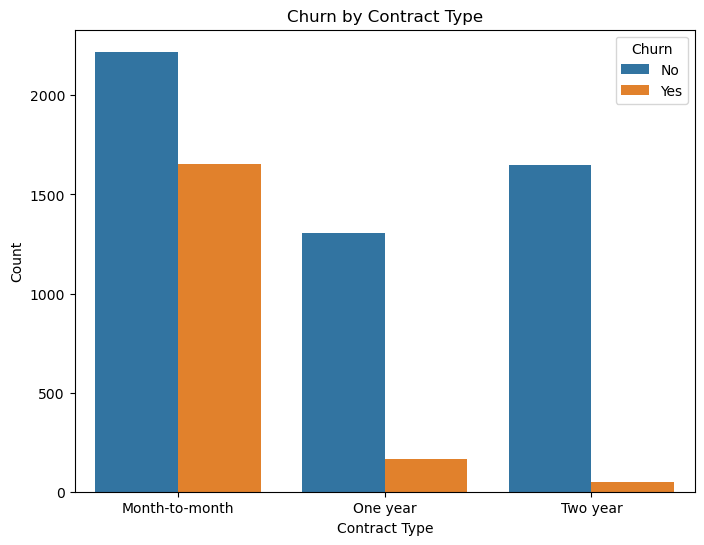

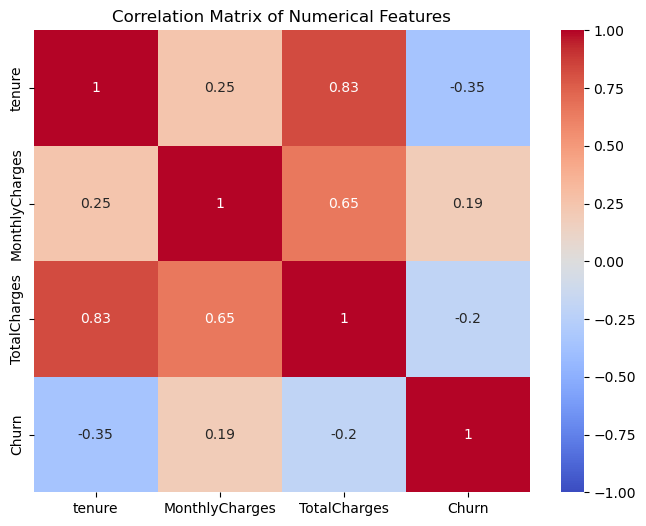

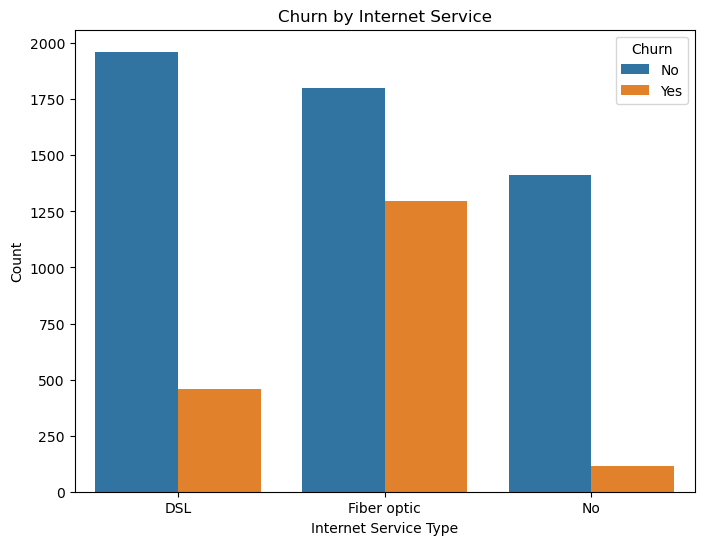

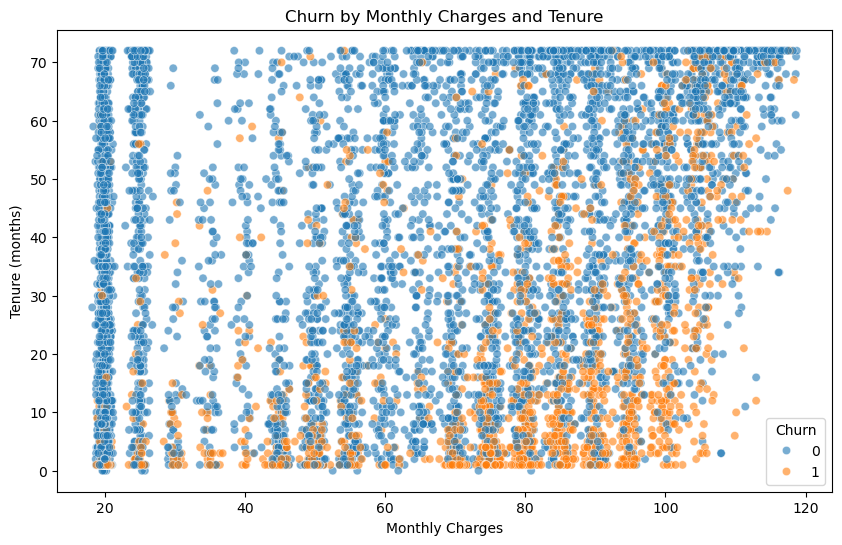

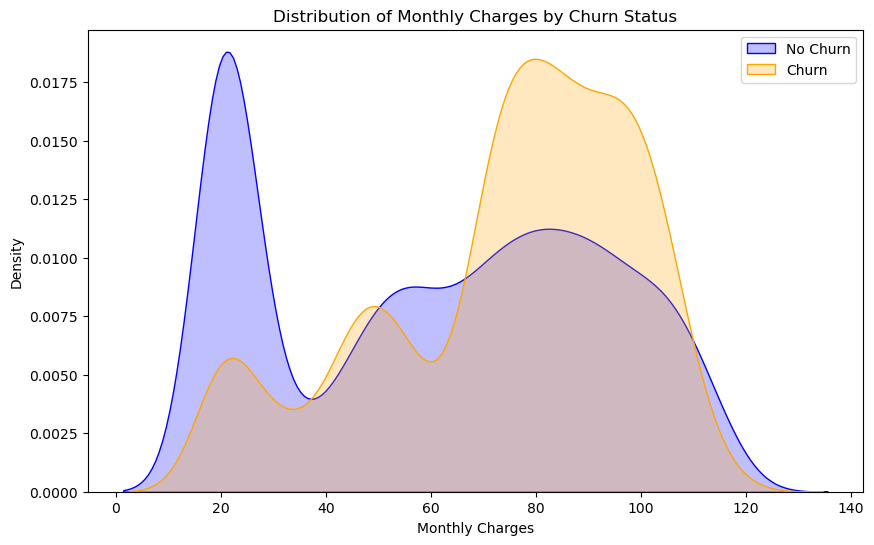

In [24]:
# Load cleaned dataset
df = pd.read_csv('cleaned_telco_data.csv')

# 1. Summary statistics for numerical features
print("Summary Statistics for Numerical Features:")
print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

# 2. Churn distribution by key categorical variables
print("\nChurn Distribution by Contract Type:")
print(df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack())

print("\nChurn Distribution by InternetService:")
print(df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack())

# 3. Correlation matrix for numerical features and Churn
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
corr_matrix = df[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# 4. Visualize churn rate by contract type
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

# Save correlation matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Churn Distribution by Internet Service
plt.figure(figsize=(8, 6))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Churn by Internet Service')
plt.xlabel('Internet Service Type')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.show()

# Churn by Monthly Charges and Tenure
# Scatter plot for MonthlyCharges
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonthlyCharges', y='tenure', hue='Churn', data=df, alpha=0.6)
plt.title('Churn by Monthly Charges and Tenure')
plt.xlabel('Monthly Charges')
plt.ylabel('Tenure (months)')
plt.show()

# Density plot for MonthlyCharges by Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Churn'] == 0]['MonthlyCharges'], label='No Churn', fill=True, color='blue')
sns.kdeplot(df[df['Churn'] == 1]['MonthlyCharges'], label='Churn', fill=True, color='orange')
plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('Monthly Charges')
plt.ylabel('Density')
plt.legend()
plt.show()

<b>EDA Insights</b>

<b>Summary Statistics:</b>

tenure: Ranges from 0 to 72 months (mean ~32.4), indicating a wide range of customer loyalty.
MonthlyCharges: Ranges from 18.25 to 118.75 (mean ~64.76), showing varied pricing plans.
TotalCharges: Ranges from 0 to 8684.8 (mean ~2279.73), with some low values possibly due to new customers or the imputed NaNs.


<b>Churn by Contract Type:</b>

Month-to-month contracts have a high churn rate (42.71%), while one-year (11.27%) and two-year (2.83%) contracts show much lower churn. This suggests longer contracts are associated with customer retention.


<b>Churn by InternetService:</b>

Fiber optic has a high churn rate (41.89%), followed by DSL (18.96%), and No Internet (7.41%). Fiber optic customers may be dissatisfied, possibly due to cost or service issues.


<b>Correlation Matrix:</b>

tenure has a strong negative correlation with Churn (-0.352), indicating longer-tenured customers are less likely to churn.
MonthlyCharges has a positive correlation with Churn (0.193), suggesting higher charges may drive churn.
TotalCharges is highly correlated with tenure (0.826), which is expected since it’s derived from tenure * MonthlyCharges in some cases.

<h3>Feature Engineering</h3>

<b>Encode categorical variables</b> :(e.g., InternetService, Contract, etc.) using one-hot encoding for non-binary categories.
<b>Scale numerical features</b>:(tenure, MonthlyCharges, TotalCharges) to ensure models like logistic regression perform well.
<b>Split the data into training and test sets</b>: (80/20 split).
<b>Handle class imbalance (since churn is imbalanced:</b> 73.46% No vs. 26.54% Yes) using oversampling (SMOTE) on the training set.

In [10]:
# 1. One-hot encode categorical variables
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'Contract', 'PaymentMethod']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2. Define features (X) and target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 3. Split data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Scale numerical features
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 5. Apply SMOTE to handle class imbalance on training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print shapes and class distribution after SMOTE
print("Training set shape after SMOTE:", X_train_resampled.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in resampled training set:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Save preprocessed data for modeling
X_train_resampled.to_csv('X_train_resampled.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train_resampled.to_csv('y_train_resampled.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

Training set shape after SMOTE: (8278, 30)
Test set shape: (1409, 30)
Class distribution in resampled training set:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


<p>The training set after SMOTE has 8,278 rows with 30 features, indicating that one-hot encoding expanded the categorical variables, and SMOTE balanced the classes perfectly (50% Churn=0, 50% Churn=1). The test set has 1,409 rows with the same 30 features, maintaining the 80/20 split (7043 * 0.2 ≈ 1409). The preprocessed data is saved for modeling.</p>

<h3>Initial Base Model development</h3>
<p>Start with a simple logistic regression model as baseline model to predict churn. Train the model, make predictions on the test set, and evaluate initial performance using accuracy, precision, recall, F1-score, and ROC-AUC.</p>

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Load preprocessed data
X_train_resampled = pd.read_csv('X_train_resampled.csv')
X_test = pd.read_csv('X_test.csv')
y_train_resampled = pd.read_csv('y_train_resampled.csv')
y_test = pd.read_csv('y_test.csv')

# Ensure y is 1D array
y_train_resampled = y_train_resampled.values.ravel()
y_test = y_test.values.ravel()

# Initialize and train logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)

# Make predictions on test set
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluate model
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

Logistic Regression Performance:
Accuracy: 0.7331440738112136
Precision: 0.4981132075471698
Recall: 0.7058823529411765
F1-Score: 0.584070796460177
ROC-AUC: 0.8219251336898397

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.87      0.74      0.80      1035
       Churn       0.50      0.71      0.58       374

    accuracy                           0.73      1409
   macro avg       0.69      0.72      0.69      1409
weighted avg       0.77      0.73      0.75      1409



<b>Accuracy (0.733):</b> The model correctly predicts 73.3% of cases, but accuracy can be misleading due to the class imbalance in the test set (73.46% No Churn vs. 26.54% Churn).<br>
<b>Precision (0.498):</b> Only 49.8% of predicted churn cases are correct, indicating many false positives.<br>
<b>Recall (0.706):</b> The model captures 70.6% of actual churn cases, which is good for identifying at-risk customers.<br>
<b>F1-Score (0.584):</b> Balances precision and recall, showing moderate performance for the Churn class.<br>
<b>ROC-AUC (0.822):</b> A strong score, indicating good discrimination between classes.<br>

<b>Classification Report:</b>

<b>No Churn:</b> High precision (0.87) and decent recall (0.74), as expected given the majority class.<br>
<b>Churn:</b> Lower precision (0.50) but good recall (0.71), suggesting the model is better at identifying churners than avoiding false positives.

The model is decent at identifying churners (high recall), but the low precision for Churn indicates it’s predicting too many non-churners as churners. The ROC-AUC is promising, suggesting potential for improvement with other models or tuning.

<h3>Model evaluation and other model development</h3>
<p><b>Random Forest:</b> Handles non-linear relationships and feature interactions well.<br>
<b>Gradient Boosting (XGBoost):</b> Powerful for imbalanced datasets and often performs well in churn prediction.</p>

In [12]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Load preprocessed data
X_train_resampled = pd.read_csv('X_train_resampled.csv')
X_test = pd.read_csv('X_test.csv')
y_train_resampled = pd.read_csv('y_train_resampled.csv')
y_test = pd.read_csv('y_test.csv')

# Ensure y is 1D array
y_train_resampled = y_train_resampled.values.ravel()
y_test = y_test.values.ravel()

# 1. Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# 2. XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate models
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_rf))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=['No Churn', 'Churn']))

Random Forest Performance:
Accuracy: 0.7572746628814763
Precision: 0.5361990950226244
Recall: 0.6336898395721925
F1-Score: 0.5808823529411765
ROC-AUC: 0.8224095171665504

Classification Report (Random Forest):
              precision    recall  f1-score   support

    No Churn       0.86      0.80      0.83      1035
       Churn       0.54      0.63      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.76      1409


XGBoost Performance:
Accuracy: 0.7579843860894251
Precision: 0.5341614906832298
Recall: 0.6898395721925134
F1-Score: 0.6021003500583431
ROC-AUC: 0.8080730579451808

Classification Report (XGBoost):
              precision    recall  f1-score   support

    No Churn       0.87      0.78      0.83      1035
       Churn       0.53      0.69      0.60       374

    accuracy                           0.76      1409
   macro avg       0.70      0.74      0.71   

<b>Observations:</b>

<b>Accuracy:</b> Random Forest (0.757) and XGBoost (0.758) slightly outperform logistic regression (0.733), but all are in a similar range.<br>
<b>Precision (Churn):</b> Random Forest (0.536) and XGBoost (0.534) improve over logistic regression (0.498), reducing false positives slightly.<br>
<b>Recall (Churn):</b> Logistic regression (0.706) and XGBoost (0.690) are strong at identifying churners, while Random Forest (0.634) is slightly lower.<br>
<b>F1-Score (Churn):</b> XGBoost (0.602) has the highest F1-score, balancing precision and recall best, followed by logistic regression (0.584) and Random Forest (0.581).<br>
<b>ROC-AUC:</b> Logistic regression and Random Forest tie at 0.822, while XGBoost is slightly lower at 0.808, but all indicate good discriminative ability.

<b>Takeaways:</b>

<b>XGBoost</b> has the best F1-score for the Churn class, making it a strong candidate for identifying at-risk customers while maintaining reasonable precision.<br>
<b>Logistic regression</b> has high recall and ROC-AUC, making it competitive despite being simpler.<br>
<b>Random Forest</b> improves precision but sacrifices some recall, which may not be ideal if prioritizing churn detection.<br>
All models could benefit from tuning, as precision for Churn is relatively low (around 0.50–0.54), indicating false positives.

<h3>Model Tuning</h3>
<p>Tune three models using grid search to optimize hyperparameters, focusing on improving the F1-score for the Churn class (since it balances precision and recall, critical for churn prediction). Cross-validation on the resampled training set to avoid overfitting.</p>

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Load preprocessed data
X_train_resampled = pd.read_csv('X_train_resampled.csv')
X_test = pd.read_csv('X_test.csv')
y_train_resampled = pd.read_csv('y_train_resampled.csv')
y_test = pd.read_csv('y_test.csv')

# Ensure y is 1D array
y_train_resampled = y_train_resampled.values.ravel()
y_test = y_test.values.ravel()

# Define F1-score as the scoring metric
f1_scorer = make_scorer(f1_score, pos_label=1)

# 1. Logistic Regression Tuning
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
logreg_grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                           logreg_param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
logreg_grid.fit(X_train_resampled, y_train_resampled)
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)
print("Best Logistic Regression F1-Score (CV):", logreg_grid.best_score_)

# 2. Random Forest Tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                       rf_param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest F1-Score (CV):", rf_grid.best_score_)

# 3. XGBoost Tuning
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'), 
                        xgb_param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)
xgb_grid.fit(X_train_resampled, y_train_resampled)
print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost F1-Score (CV):", xgb_grid.best_score_)

# Save best models for final evaluation
import joblib
joblib.dump(logreg_grid.best_estimator_, 'best_logreg_model.pkl')
joblib.dump(rf_grid.best_estimator_, 'best_rf_model.pkl')
joblib.dump(xgb_grid.best_estimator_, 'best_xgb_model.pkl')

Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression F1-Score (CV): 0.7964852322434741
Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest F1-Score (CV): 0.8490012222046459
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best XGBoost F1-Score (CV): 0.8324165889938803


['best_xgb_model.pkl']

<b>Logistic Regression:</b> Best parameters {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} with F1-score 0.796. The L1 penalty suggests some feature selection occurred.<br>
<b>Random Forest:</b> Best parameters {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100} with the highest F1-score of 0.849, indicating strong performance.<br>
<b>XGBoost:</b> Best parameters {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200} with F1-score 0.832, also performing well but slightly behind Random Forest.<br>

These F1-scores (on the resampled training set) suggest Random Forest is the strongest candidate, followed by XGBoost and Logistic Regression. Now, we need to evaluate the tuned models on the test set to confirm their generalization performance.

<h3>Model tuning of all and final selection</h3>
<p>Evaluate the tuned models on the test set using the same metrics (accuracy, precision, recall, F1-score, ROC-AUC) to select the final model. We’ll load the saved models and compare their performance to choose the one with the best balance of metrics, prioritizing the F1-score for the Churn class (since it balances precision and recall, critical for churn prediction).</p>

Tuned Logistic Regression Performance:
              precision    recall  f1-score   support

    No Churn       0.87      0.75      0.81      1035
       Churn       0.50      0.70      0.58       374

    accuracy                           0.73      1409
   macro avg       0.69      0.72      0.69      1409
weighted avg       0.77      0.73      0.75      1409


Tuned Random Forest Performance:
              precision    recall  f1-score   support

    No Churn       0.86      0.81      0.83      1035
       Churn       0.54      0.64      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.76      0.77      1409


Tuned XGBoost Performance:
              precision    recall  f1-score   support

    No Churn       0.87      0.78      0.82      1035
       Churn       0.53      0.69      0.60       374

    accuracy                           0.75      1409
   macro avg       0.70    

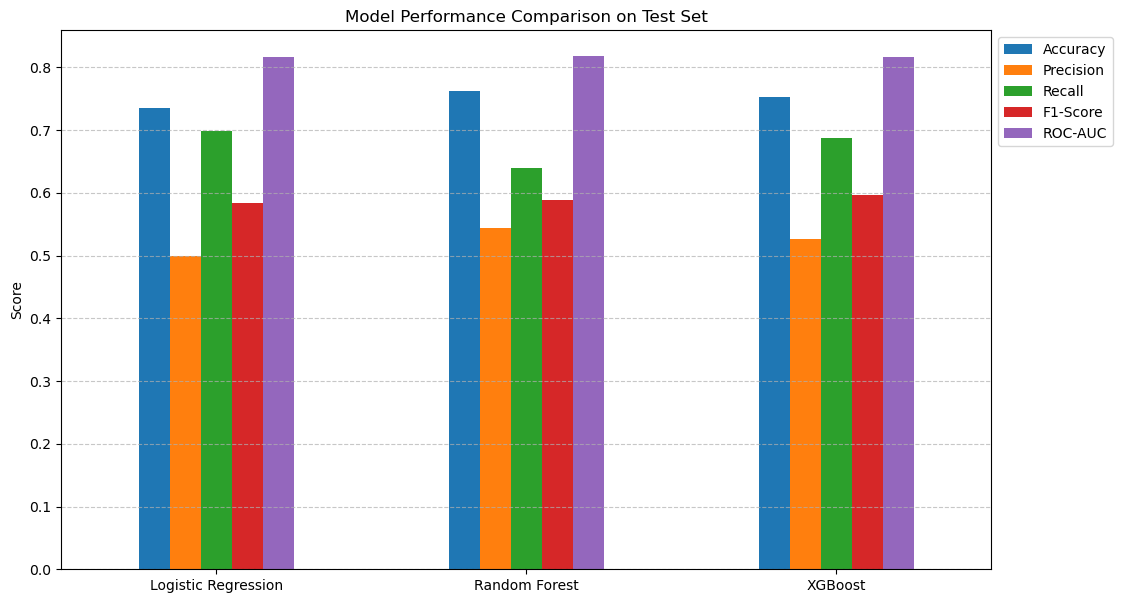

In [25]:
# Load preprocessed test data
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

# Ensure y_test is 1D array
y_test = y_test.values.ravel()

# Load tuned models
logreg_tuned = joblib.load('best_logreg_model.pkl')
rf_tuned = joblib.load('best_rf_model.pkl')
xgb_tuned = joblib.load('best_xgb_model.pkl')

# Dictionary to store results
results = {}

# Evaluate Logistic Regression
y_pred_logreg = logreg_tuned.predict(X_test)
y_pred_proba_logreg = logreg_tuned.predict_proba(X_test)[:, 1]
results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_logreg),
    'Precision': precision_score(y_test, y_pred_logreg),
    'Recall': recall_score(y_test, y_pred_logreg),
    'F1-Score': f1_score(y_test, y_pred_logreg),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_logreg)
}
print("Tuned Logistic Regression Performance:")
print(classification_report(y_test, y_pred_logreg, target_names=['No Churn', 'Churn']))

# Evaluate Random Forest
y_pred_rf = rf_tuned.predict(X_test)
y_pred_proba_rf = rf_tuned.predict_proba(X_test)[:, 1]
results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1-Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf)
}
print("\nTuned Random Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=['No Churn', 'Churn']))

# Evaluate XGBoost
y_pred_xgb = xgb_tuned.predict(X_test)
y_pred_proba_xgb = xgb_tuned.predict_proba(X_test)[:, 1]
results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1-Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_xgb)
}
print("\nTuned XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb, target_names=['No Churn', 'Churn']))

# Print comparison table
print("\nModel Comparison:")
print(pd.DataFrame(results).T.round(3))

# Model Performance Comparison Bar Chart
metrics_df = pd.DataFrame(results).T.round(3)
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.title('Model Performance Comparison on Test Set')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Save final comparison
pd.DataFrame(results).T.to_csv('model_comparison.csv')

<h3>Final model selection: XGBoost</h3>

<b>Analysis:</b>

<b>Accuracy:</b> Random Forest (0.762) has the highest accuracy, followed by XGBoost (0.752) and Logistic Regression (0.735). All are close, but Random Forest edges out.<br>
<b>Precision (Churn):</b> Random Forest (0.544) has the highest precision, followed by XGBoost (0.526) and Logistic Regression (0.500). Higher precision means fewer false positives, which is important to avoid targeting non-churning customers.<br>
<b>Recall (Churn):</b> Logistic Regression (0.698) and XGBoost (0.687) have higher recall than Random Forest (0.639), meaning they identify more actual churners. High recall is critical for churn prediction to catch at-risk customers.<br>
<b>F1-Score (Churn):</b> XGBoost (0.596) has the highest F1-score, balancing precision and recall best, followed by Random Forest (0.588) and Logistic Regression (0.583).<br>
<b>ROC-AUC:</b> Random Forest (0.818) slightly outperforms Logistic Regression and XGBoost (both 0.816), indicating good discriminative ability across all models.

<b>Key Observations:</b>

<b>XGBoost</b> has the highest F1-score for the Churn class (0.596), making it the best at balancing precision and recall. Its recall (0.687) is strong, ensuring most churners are identified, and its precision (0.526) is reasonable.<br>
<b>Random Forest</b> has the highest accuracy (0.762) and precision (0.544) but lower recall (0.639), missing some churners compared to XGBoost.</br>
<b>Logistic Regression</b> performs comparably to XGBoost in recall (0.698) but has the lowest precision (0.500), leading to more false positives and a slightly lower F1-score (0.583).<br>
All models have similar ROC-AUC scores (~0.816–0.818), indicating good overall discriminative power.

<b>Final Model Selection:</b>
Given the goal of predicting customer churn, we prioritize the F1-score for the Churn class to balance identifying churners (recall) and avoiding false positives (precision). XGBoost is the best choice with the highest F1-score (0.596) and strong recall (0.687), making it effective for identifying at-risk customers while maintaining reasonable precision. Random Forest is a close second, but its lower recall makes it less ideal for capturing churners. Logistic Regression, while simpler, has lower precision, leading to more false positives.

<h3>XGBoost Feature Importance</h3>

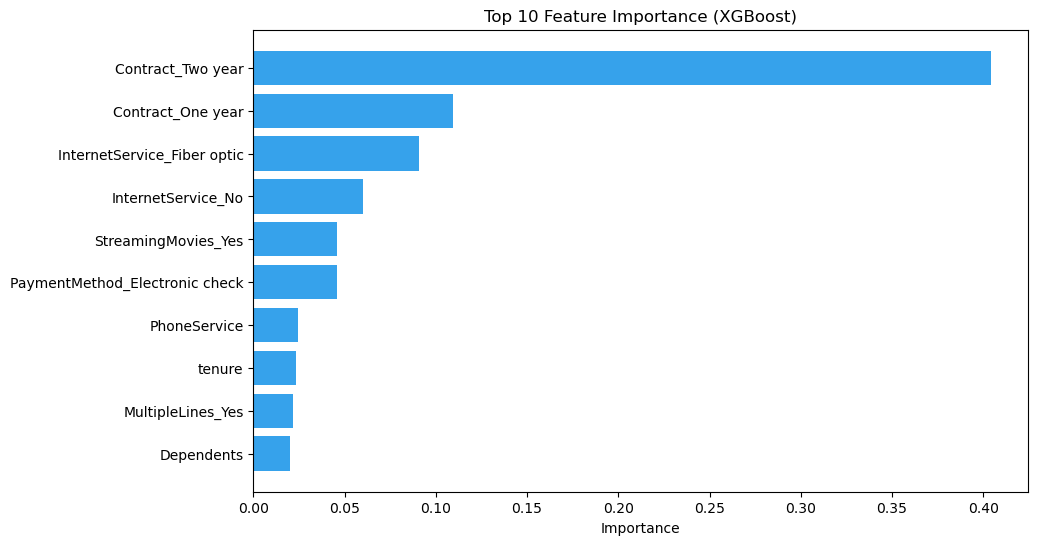

Feature Importance:
                           Feature  Importance
26               Contract_Two year    0.404520
25               Contract_One year    0.109308
11     InternetService_Fiber optic    0.090739
12              InternetService_No    0.060016
24             StreamingMovies_Yes    0.046072
28  PaymentMethod_Electronic check    0.045797
5                     PhoneService    0.024527
4                           tenure    0.023226
10               MultipleLines_Yes    0.021635
3                       Dependents    0.020338


In [15]:
# Load the tuned XGBoost model
xgb_tuned = joblib.load('best_xgb_model.pkl')

# Get feature importance
feature_importance = xgb_tuned.feature_importances_
features = pd.read_csv('X_test.csv').columns

# Create DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='#36A2EB')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

# Print feature importance
print("Feature Importance:")
print(importance_df.head(10))

<h3>Final Model</h3>
<p>The tuned XGBoost model (F1-score: 0.596, recall: 0.687, precision: 0.526) is the final selection due to its balanced performance on the Churn class. It effectively identifies at-risk customers while maintaining reasonable precision, and its feature importance aligns with EDA findings.<br>If higher recall is needed (e.g., to catch more churners), adjust the classification threshold.</p>

<h3>Creating new feature and training tuned xgb</h3>

Tuned XGBoost with Derived Features Performance:
Accuracy: 0.7650816181689141
Precision: 0.5485327313769752
Recall: 0.6497326203208557
F1-Score: 0.594859241126071
ROC-AUC: 0.8201658529024258

Classification Report (XGBoost with Derived Features):
              precision    recall  f1-score   support

    No Churn       0.86      0.81      0.83      1035
       Churn       0.55      0.65      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.77      0.77      1409


Feature Importance (Top 10):
                                         Feature  Importance
27  Contract_Internet_Month-to-month_Fiber optic    0.371971
21                             Contract_Two year    0.087307
13                            InternetService_No    0.081869
31                 Contract_Internet_One year_No    0.069668
23                PaymentMethod_Electronic check    0.035902
19                            

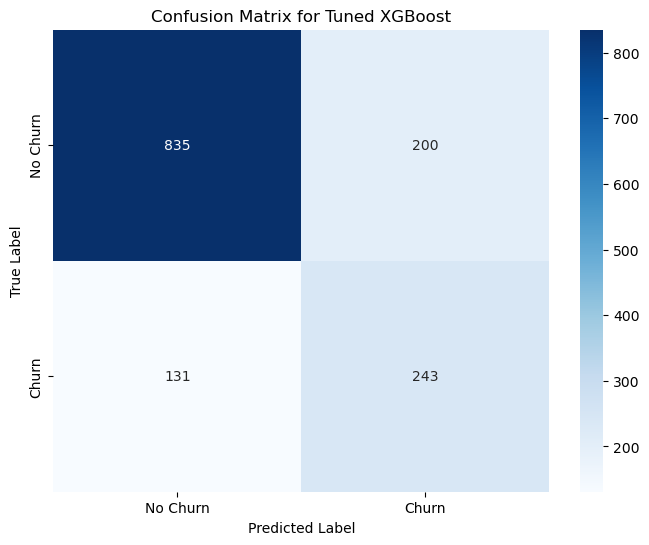

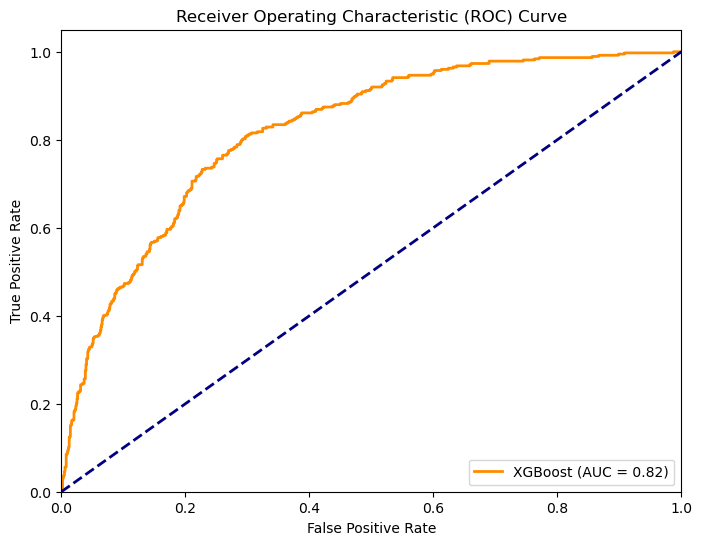

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix,roc_curve,auc
import joblib

# Load the cleaned dataset
df = pd.read_csv('cleaned_telco_data.csv')

# 1. Create derived features
# Average Monthly Charges (avoid division by zero)
df['AvgMonthlyCharges'] = np.where(df['tenure'] > 0, df['TotalCharges'] / df['tenure'], df['MonthlyCharges'])

# Service Count: Convert service-related columns to binary (0/1)
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Map categorical service columns to numeric (Yes=1, No/No phone service/No internet service=0)
for col in service_cols:
    # Check if the column contains string values before mapping
    if df[col].dtype == 'object':
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0})
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(0) # Fill NaN with 0

# Convert InternetService to binary (1 if DSL or Fiber optic, 0 if No)
df['InternetService_Binary'] = df['InternetService'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0})
if df['InternetService_Binary'].isna().sum() > 0:
    df['InternetService_Binary'] = df['InternetService_Binary'].fillna(0)

# Calculate ServiceCount
df['ServiceCount'] = df[service_cols + ['InternetService_Binary']].sum(axis=1)

# Tenure Bins
df['TenureBin'] = pd.cut(df['tenure'], bins=[-1, 12, 36, 72], labels=['Short', 'Medium', 'Long'])

# Contract-Service Interaction
df['Contract_Internet'] = df['Contract'] + '_' + df['InternetService']

# 2. One-hot encode categorical variables
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaymentMethod', 'TenureBin', 'Contract_Internet']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop temporary InternetService_Binary
df_encoded = df_encoded.drop('InternetService_Binary', axis=1)

# 3. Define features (X) and target (y)
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

# 4. Split data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Scale numerical features
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges', 'ServiceCount']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 6. Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 7. Retrain tuned XGBoost model with best parameters
xgb_tuned = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=200, random_state=42, eval_metric='logloss')
xgb_tuned.fit(X_train_resampled, y_train_resampled)

# 8. Evaluate on test set
y_pred_xgb = xgb_tuned.predict(X_test)
y_pred_proba_xgb = xgb_tuned.predict_proba(X_test)[:, 1]

print("Tuned XGBoost with Derived Features Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("\nClassification Report (XGBoost with Derived Features):")
print(classification_report(y_test, y_pred_xgb, target_names=['No Churn', 'Churn']))

# 9. Feature importance
feature_importance = xgb_tuned.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Top 10):")
print(importance_df.head(10))

# Confusion Matrix Heatmap for XGBoost
y_pred_xgb = xgb_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix for Tuned XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve for XGBoost
y_pred_proba_xgb = xgb_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Save the new model and data
joblib.dump(xgb_tuned, 'best_xgb_with_derived_features.pkl')
X_test.to_csv('X_test_with_derived.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

<b>Insights:</b>

<b>Contract_Internet_Month-to-month_Fiber optic (0.372):</b> This derived feature is the most important, capturing the high-churn combination of month-to-month contracts and fiber optic service (EDA: 41.89% churn for fiber optic). It significantly enhances the model’s ability to identify at-risk customers.<br>
<b>ServiceCount (0.019):</b>In top 10, indicating modest usefulness in summarizing customer engagement (more services may correlate with loyalty or higher costs).<br>
<b>AvgMonthlyCharges and TenureBin:</b> Not in the top 10, suggesting less predictive or redundant with MonthlyCharges and tenure.<br>
<b>Other Features:</b> Contract_Two year, InternetService_No, and PaymentMethod_Electronic check remain important, consistent with the baseline model.

<h3>Business Implications</h3>
<p><b>Contract Type:</b>Promote longer-term contracts (one- or two-year) to reduce churn, as they are the strongest predictors of retention.<br><b>Internet Service:</b>Investigate dissatisfaction among fiber optic customers (e.g., cost, reliability) to address high churn.<br><b>Payment Methods:</b>Electronic check users may need better support or incentives to stay.<br><b>Streaming Services:</b>Evaluate whether streaming subscriptions correlate with higher charges driving churn.<br></p>

<h3>Deployment</h3> 
<p>Create scaler.pkl and preprocessor_data.pkl</p>

In [32]:
#import joblib
#import pandas as pd
#import numpy as np
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler

#Load the cleaned dataset
#df = pd.read_csv('cleaned_telco_data.csv')

#Feature Engineering
df['AvgMonthlyCharges'] = np.where(df['tenure'] > 0, df['TotalCharges'] / df['tenure'], df['MonthlyCharges'])

# Service-related columns for ServiceCount
service_cols_for_count = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
                         'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Map categorical service columns to numeric (Yes=1, No/No phone service/No internet service=0)
for col in service_cols_for_count:
    if df[col].dtype == 'object':
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0})
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(0)

# Convert InternetService to binary for ServiceCount calculation
df['InternetService_Binary'] = df['InternetService'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0})
df['InternetService_Binary'] = df['InternetService_Binary'].fillna(0)

# Calculate ServiceCount
df['ServiceCount'] = df[service_cols_for_count + ['InternetService_Binary']].sum(axis=1)

# Tenure Bins
df['TenureBin'] = pd.cut(df['tenure'], bins=[-1, 12, 36, 72], labels=['Short', 'Medium', 'Long'])

# Contract-Service Interaction
df['Contract_Internet'] = df['Contract'] + '_' + df['InternetService']

# --- Preprocessing for the Model ---
# Identify all categorical and numerical columns
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaymentMethod', 'TenureBin', 'Contract_Internet']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharges', 'ServiceCount']

# One-hot encode the categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop temporary InternetService_Binary column
df_encoded = df_encoded.drop('InternetService_Binary', axis=1)

# Define features (X)
X = df_encoded.drop('Churn', axis=1)

# Split the data to get the training set columns
X_train, _, _, _ = train_test_split(X, df['Churn'], test_size=0.2, random_state=42, stratify=df['Churn'])

# Fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])

# Save the scaler, preprocessing data, and training columns
preprocessor_data = {
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols,
    'encoded_cols': list(X_train.columns)
}

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(preprocessor_data, 'preprocessor_data.pkl')
joblib.dump(list(X_train.columns), 'training_columns.pkl')

print("Preprocessing data and training columns have been saved.")

Preprocessing data and training columns have been saved.
